# Example 2

1. Download the data from https://www.kaggle.com/whitebird/ieee-internal-blend into folder “input”. 
2. Generate the features：  
  python f3deepwalk.py  
  python fdkey.py  
  python feV307.py  
  python fiyu.py  
3. Run this notebook.

In [1]:
import os
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random,math
import pickle
from sklearn.linear_model import LinearRegression 
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
from collections import Counter
from math import log2,log10
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent
import lightgbm as lgb
def metric(true,pred):
    thre = 0.2
    pred = (pred > thre).astype(int)
    p = np.sum(pred*true)/(np.sum(pred) + 0.01)
    r = np.sum(pred*true)/(np.sum(true) + 0.01)
    return p,r,2*p*r/(p+r)

In [2]:
train_transaction = pd.read_csv('./input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('./input/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('./input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('./input/test_identity.csv', index_col='TransactionID')
sample_submission = pd.read_csv('./input/sample_submission.csv', index_col='TransactionID')

train_f5 = pd.read_csv('./input/fd_train4.csv', index_col='TransactionID')
test_f5 = pd.read_csv('./input/fd_test4.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

train_f5 = pd.read_csv('./input/fe_train3.csv', index_col='TransactionID')
test_f5 = pd.read_csv('./input/fe_test3.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

train_f5 = pd.read_csv('./input/fi_train4.csv', index_col='TransactionID')
test_f5 = pd.read_csv('./input/fi_test4.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)
debug = True

In [3]:
train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
test_transaction['TransactionDT2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600+22)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600+22)%24)
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
train_transaction['TransactionAmt_decimal'] = ((train_transaction['TransactionAmt'] - train_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
test_transaction['TransactionAmt_decimal'] = ((test_transaction['TransactionAmt'] - test_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
train_test = train_transaction.append(test_transaction)
for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
    train_transaction["_".join(col)] = train_transaction[col[0]].fillna(-1).map(str) + "_" + train_transaction[col[1]].fillna(-1).map(str)
    test_transaction["_".join(col)] = test_transaction[col[0]].fillna(-1).map(str) + "_" + test_transaction[col[1]].fillna(-1).map(str)
    
train_test = train_transaction.append(test_transaction)


for col in ["card1","card1_card2","card2_addr1"]:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)

for col in [["card2","addr1"],["card1","card2"],["card1","addr1"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    del train_transaction["_".join(col)],test_transaction["_".join(col)]
    
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    
for col in "card1,card2,card3,card4,card5,addr1".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
    col_count = train_test.groupby(col)['TransactionAmt'].std()
    train_transaction[col+'_amtscount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtscount'] = test_transaction[col].map(col_count)
    
    for col2 in "C5,C8".split(','):
        col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    for col2 in "C13".split(','):
        col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
        
train_transaction['TransactionAmt_to_mean_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_mean_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_std_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
train_transaction['TransactionAmt_to_std_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_mean_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_mean_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_std_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_std_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('std')

train_transaction['D15_to_mean_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('mean')
train_transaction['D15_to_mean_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('mean')
train_transaction['D15_to_std_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('std')
train_transaction['D15_to_std_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('std')

test_transaction['D15_to_mean_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('mean')
test_transaction['D15_to_mean_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('mean')
test_transaction['D15_to_std_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('std')
test_transaction['D15_to_std_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('std')

train_transaction['D15_to_mean_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('mean')
train_transaction['D15_to_std_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('std')

test_transaction['D15_to_mean_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('mean')
test_transaction['D15_to_std_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('std')

train_transaction['uid'] = train_transaction['card1'].astype(str)+'_'+train_transaction['card2'].astype(str)+'_'+train_transaction['card3'].astype(str)+'_'+train_transaction['card4'].astype(str)
test_transaction['uid'] = test_transaction['card1'].astype(str)+'_'+test_transaction['card2'].astype(str)+'_'+test_transaction['card3'].astype(str)+'_'+test_transaction['card4'].astype(str)

train_transaction['uid2'] = train_transaction['uid'].astype(str)+'_'+train_transaction['addr1'].astype(str)+'_'+train_transaction['addr2'].astype(str)
test_transaction['uid2'] = test_transaction['uid'].astype(str)+'_'+test_transaction['addr1'].astype(str)+'_'+test_transaction['addr2'].astype(str)

train_transaction['temp'] = train_transaction['TransactionDT2'].astype(str) + train_transaction['uid2'].astype(str) + train_transaction['TransactionAmt'].astype(str)
test_transaction['temp'] = test_transaction['TransactionDT2'].astype(str) + test_transaction['uid2'].astype(str) + test_transaction['TransactionAmt'].astype(str)




train_transaction['D16'] = train_transaction['D15'] - train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
test_transaction['D16'] = test_transaction['D15'] - test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))

for col in "D1,D2,D3,D4,D10".split(','):
    train_transaction[col + "_day"] = train_transaction[col] - train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
    test_transaction[col + "_day"] = test_transaction[col] - test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
    


col_del_oof = []    
col_del_amt = []
for col in [['TransactionDT2','uid2','TransactionAmt']]: 
    col_count1 = train_transaction.groupby('temp')['isFraud'].sum()
    train_transaction['isFraud_s1'] = train_transaction['temp'].map(col_count1) - train_transaction['isFraud']
    col_count1 = train_transaction.groupby('temp')['isFraud'].count()
    train_transaction['isFraud_s1_1'] = (train_transaction['isFraud_s1'])/(train_transaction['temp'].map(col_count1) - 0.99999)
    
    
    train_transaction["_".join(col)+'_hourmean'] = train_transaction.groupby('temp')['hour'].transform('mean')
    test_transaction["_".join(col)+'_hourmean'] = test_transaction.groupby('temp')['hour'].transform('mean')
    
    train_transaction['TransactionAmt_daysum'] = train_transaction.groupby('temp')['TransactionAmt'].transform('sum')
    test_transaction['TransactionAmt_daysum'] = test_transaction.groupby('temp')['TransactionAmt'].transform('sum')
    col_del_amt.append('TransactionAmt_daysum')
    col_del_amt.append('TransactionAmt_ukeyen')
    for col2 in "C8,C13,D15".split(','):
        col_count1 = train_transaction[train_transaction[col2] == 0].groupby('temp')[col2].count()
        train_transaction["_".join(col)+'_'+col2+'count'] = (train_transaction['temp'].map(col_count1) /
                                                             train_transaction.fillna(-1).groupby('temp')['TransactionAmt'].transform('count'))
        col_count1 = test_transaction[test_transaction[col2] == 0].groupby('temp')[col2].count()
        test_transaction["_".join(col)+'_'+col2+'count'] = (test_transaction['temp'].map(col_count1)/
                                                             test_transaction.fillna(-1).groupby('temp')['TransactionAmt'].transform('count'))
        col_del_amt.append("_".join(col)+'_'+col2+'count')

    for col2 in "D1_day,D4_day,D15,D16".split(','):
        train_transaction["_".join(col)+'_'+col2+'mcount'] = ( 
                                                             train_transaction.groupby('temp')[col2].transform('mean'))
        test_transaction["_".join(col)+'_'+col2+'mcount'] = ( 
                                                             test_transaction.groupby('temp')[col2].transform('mean'))
        col_del_amt.append("_".join(col)+'_'+col2+'mcount')
    for col2 in "C1,C5,C8,D1,D4_day,D15,D16,V307,V310,V127".split(','):
        train_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             train_transaction.groupby('temp')[col2].transform('std'))
        test_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             test_transaction.groupby('temp')[col2].transform('std'))
        col_del_amt.append("_".join(col)+'_'+col2+'scount')
        
# id
col_del_ukey2 = []
for col in [['tempkey']]: 
    col_count1 = train_transaction.groupby('tempkey')['isFraud'].sum()
    train_transaction['isFraud_s2'] = train_transaction['tempkey'].map(col_count1) - train_transaction['isFraud']
    
    train_transaction["_".join(col)+'_hourmean'] = train_transaction.groupby('tempkey')['hour'].transform('mean')
    test_transaction["_".join(col)+'_hourmean'] = test_transaction.groupby('tempkey')['hour'].transform('mean')
    
    train_transaction['TransactionAmt_ukeycount'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('count')
    test_transaction['TransactionAmt_ukeycount'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('count')
    col_del_ukey2.append('TransactionAmt_ukeysum')
    
    col_count = train_transaction.groupby(col[0])['card1'].apply(entropy)
    train_transaction['en_' + col[0] +'card1' + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])['card1'].apply(entropy)
    test_transaction['en_' + col[0] +'card1' + '_count'] = test_transaction[col[0]].map(col_count) 
    col_del_ukey2.append('en_' + col[0] +'card2' + '_count')
    
    col_count = train_transaction.groupby(col[0])['card2'].apply(entropy)
    train_transaction['en_' + col[0] +'card2' + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])['card2'].apply(entropy)
    test_transaction['en_' + col[0] +'card2' + '_count'] = test_transaction[col[0]].map(col_count)    
    col_del_ukey2.append('en_' + col[0] +'card2' + '_count')
    
    
# V307
col_del_ukey = []
for col in [['ukey']]: 
    col_count1 = train_transaction.groupby('ukey')['isFraud'].sum()
    train_transaction['isFraud_s3'] = train_transaction['ukey'].map(col_count1) - train_transaction['isFraud']
    
    train_transaction['TransactionAmt_ukeysum'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('sum')
    test_transaction['TransactionAmt_ukeysum'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('sum')
    train_transaction['TransactionAmt_ukeystd'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('std')
    test_transaction['TransactionAmt_ukeystd'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('std')
    col_del_ukey.append('TransactionAmt_ukeysum')
    col_del_ukey.append('TransactionAmt_ukeystd')
    
    for col2 in "C3,C5,C7,C13,D1,D15".split(','):
        col_count1 = train_transaction[train_transaction[col2] == 0].groupby('ukey')[col2].count()
        train_transaction["_".join(col)+'_'+col2+'count'] = (train_transaction['ukey'].map(col_count1) /
                                                             train_transaction.groupby(col)['TransactionAmt'].transform('count'))
        col_count1 = test_transaction[test_transaction[col2] == 0].groupby('ukey')[col2].count()
        test_transaction["_".join(col)+'_'+col2+'count'] = (test_transaction['ukey'].map(col_count1)/
                                                             test_transaction.groupby(col)['TransactionAmt'].transform('count'))
        col_del_ukey.append("_".join(col)+'_'+col2+'count')
        
    for col2 in "C1,C4,C13,D10_day,D4_day,D16".split(','):
        train_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             train_transaction.groupby(col)[col2].transform('std'))
        test_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             test_transaction.groupby(col)[col2].transform('std'))
        col_del_ukey.append("_".join(col)+'_'+col2+'scount')
        

train_transaction['TransactionDT3'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
test_transaction['TransactionDT3'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
train_transaction['uid2'] = train_transaction['uid'].astype(str)+'_'+train_transaction['addr1'].astype(str)+'_'+train_transaction['P_emaildomain'].astype(str)
test_transaction['uid2'] = test_transaction['uid'].astype(str)+'_'+test_transaction['addr1'].astype(str)+'_'+test_transaction['P_emaildomain'].astype(str)

train_transaction['temp'] = train_transaction['TransactionDT3'].astype(str) + train_transaction['uid2'].astype(str) 
test_transaction['temp'] = test_transaction['TransactionDT3'].astype(str) + test_transaction['uid2'].astype(str) 



train_test = train_transaction.append(test_transaction)
d_cols=['D1_day']
for i in d_cols:
    train_test[str(i)+'_mean'] = train_test[i]/train_test.groupby('uid2')[i].transform('mean')
    train_test[str(i)+'_std']  = train_test[i]/train_test.groupby('uid2')[i].transform('std')
    train_transaction[str(i)+'_mean'] = train_test.loc[train_transaction.index,str(i)+'_mean']
    train_transaction[str(i)+'_std'] = train_test.loc[train_transaction.index,str(i)+'_std']
    test_transaction[str(i)+'_mean'] = train_test.loc[test_transaction.index,str(i)+'_mean']
    test_transaction[str(i)+'_std']  = train_test.loc[test_transaction.index,str(i)+'_std']

for col in [['card123456_add1_D15_series']]: 
    col_count1 = train_transaction.groupby('card123456_add1_D15_series')['isFraud'].sum()
    train_transaction['isFraud_s4'] = train_transaction['card123456_add1_D15_series'].map(col_count1) - train_transaction['isFraud']
    
train_transaction['temp'] = train_transaction['TransactionDT2'].astype(str) + train_transaction['TransactionAmt'].astype(str)
test_transaction['temp'] = test_transaction['TransactionDT2'].astype(str) + test_transaction['TransactionAmt'].astype(str)
    
for col in [['TransactionDT2','TransactionAmt']]: 
    col_count1 = train_transaction.groupby('temp')['isFraud'].sum()
    train_transaction['isFraud_s5'] = train_transaction['temp'].map(col_count1) - train_transaction['isFraud']
    col_count1 = train_transaction.groupby('temp')['isFraud'].count()
    train_transaction['isFraud_s5_1'] = (train_transaction['isFraud_s5'])/(train_transaction['temp'].map(col_count1) - 0.99999)
    
    
del train_transaction['tempkey'],test_transaction['tempkey']
del train_transaction['temp'],test_transaction['temp']
del train_transaction['uid'],test_transaction['uid']
del train_transaction['uid2'],test_transaction['uid2']

del train_transaction['ukey'],test_transaction['ukey']
del train_transaction['TransactionDT3'],test_transaction['TransactionDT3']

train_test['card123456_D2_series_D15_max'] = train_test.groupby('card123456_add1_D15_series')['D3'].transform('max')
train_test['card123456_D2_series_D15_min'] = train_test.groupby('card123456_add1_D15_series')['D3'].transform('min')
train_test['card123456_D2_series_D15_std'] = train_test.groupby('card123456_add1_D15_series')['D3'].transform('std')

train_transaction['card123456_D2_series_D15_max']       = train_test.loc[train_transaction.index,'card123456_D2_series_D15_max']
test_transaction['card123456_D2_series_D15_max']       = train_test.loc[test_transaction.index,'card123456_D2_series_D15_max']

train_transaction['card123456_D2_series_D15_min']       = train_test.loc[train_transaction.index,'card123456_D2_series_D15_min']
test_transaction['card123456_D2_series_D15_min']       = train_test.loc[test_transaction.index,'card123456_D2_series_D15_min']

train_transaction['card123456_D2_series_D15_std']       = train_test.loc[train_transaction.index,'card123456_D2_series_D15_std']
test_transaction['card123456_D2_series_D15_std']       = train_test.loc[test_transaction.index,'card123456_D2_series_D15_std']

del train_transaction['card123456_add1_D2_series'],test_transaction['card123456_add1_D2_series']
del train_transaction['card123456_add1_D15_series'],test_transaction['card123456_add1_D15_series']

for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
    col_count = train_test.fillna(-1).groupby(col)['TransactionDT'].count()
    minnum = col_count[col_count == 1].index.min()
    train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
    test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)

col_del3 = []
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    col_del3.append(col+'_fix')
    
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_04,id_05,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,DeviceType,DeviceInfo".split(","):
    navalue = -1
    if col in ['id_01','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10']:
        navalue = -999
    col_count = train_test.fillna(navalue).groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(navalue).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(navalue).map(col_count)

train = train_transaction.merge(train_identity.fillna(-1) , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity.fillna(-1) , how='left', left_index=True, right_index=True)
train_test = train.append(test).fillna(-1)
for col in "card1,card2,card5".split(","):
    
    for col2 in "id_01".split(','):
        col_count1 = train_test[train_test[col2].isna()].groupby(col)[col].count()
        col_count2 = train_test.groupby(col)[col].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count1) / (train_transaction[col].map(col_count2) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count1) / (test_transaction[col].map(col_count2) + 0.01)

del train_test,train,test

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)


test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()

target_col = [x for x in train.columns.tolist() if x.startswith('isFraud_s') ]
print(target_col)
y_train_s = train[target_col].copy()
y_test_s = test[['isFraud'] * len(target_col)].copy()

del train_identity, test_identity
del train_transaction, test_transaction
del train['TransactionDT'],test['TransactionDT']
del train['TransactionDT2'],test['TransactionDT2']
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

X_train = X_train.drop(target_col,axis = 1)

del test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        if f in ['id_17','id_19','id_20','id_21','id_25','id_26']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))  
        
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


X_train = reduce_mem_usage(X_train)
if not debug:
    X_test = reduce_mem_usage(X_test)


if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]
    
    y_test_s = y_train_s.iloc[split_pos:]
    y_train_s = y_train_s.iloc[:split_pos]


/home/yingzhenzhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:260: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/yingzhenzhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:260: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/yingzhenzhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:260: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/yingzhenzhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:260: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/yingzhenzhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:260: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/yingzhenzhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:260: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/yingzhenzhe/.local/lib/python3.6/site-packages/ipykernel_l

['isFraud_s1', 'isFraud_s1_1', 'isFraud_s2', 'isFraud_s3', 'isFraud_s4', 'isFraud_s5', 'isFraud_s5_1']
Memory usage of dataframe is 2840.42 MB
Memory usage after optimization is: 856.33 MB
Decreased by 69.9%


# Single task - LGB

In [5]:
features = [x for x in X_train.columns ]  
cate = []
print(cate)
params = {
          'boosting': 'gbdt',
          'metric': 'auc',
          'max_depth': 16,
          'learning_rate': 0.03,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 25,
          "num_threads":6,
          'metric_freq':10,
          'data_random_seed': 17,
         'objective':'binary'}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 600
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_singlelgb = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
    model.set_num_labels(1)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_singlelgb += temp / folds
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_singlelgb),log_loss(y_test, y_singlelgb),metric(y_test, y_singlelgb))  



[]
{'boosting': 'gbdt', 'metric': 'auc', 'max_depth': 16, 'learning_rate': 0.03, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500, 'min_child_weight': 0.1, 'min_data_in_leaf': 25, 'num_threads': 6, 'metric_freq': 10, 'data_random_seed': 17, 'objective': 'binary'}


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[30]	valid_0's auc: 0.942922	valid_1's auc: 0.907249
[60]	valid_0's auc: 0.956821	valid_1's auc: 0.917659
[90]	valid_0's auc: 0.965139	valid_1's auc: 0.926427
[120]	valid_0's auc: 0.969578	valid_1's auc: 0.93253
[150]	valid_0's auc: 0.971946	valid_1's auc: 0.935317
[180]	valid_0's auc: 0.97354	valid_1's auc: 0.937167
[210]	valid_0's auc: 0.974582	valid_1's auc: 0.938082
[240]	valid_0's auc: 0.975385	valid_1's auc: 0.938556
[270]	valid_0's auc: 0.976087	valid_1's auc: 0.938568
[300]	valid_0's auc: 0.976488	valid_1's auc: 0.938633
[330]	valid_0's auc: 0.976715	valid_1's auc: 0.938579
[360]	valid_0's auc: 0.977021	valid_1's auc: 0.938501
[390]	valid_0's auc: 0.977048	valid_1's auc: 0.938679
[420]	valid_0's auc: 0.977112	valid_1's auc: 0.938728
[450]	valid_0's auc: 0.977148	valid_1's auc: 0.938751
[480]	valid_0's auc: 0.977155	valid_1's auc: 0.938731
[510]	valid_0's auc: 0.977123	valid_1's auc: 0.938468
[540]	valid_0's auc: 0.977044	valid_1's auc: 0.938348
[570]	valid_0's auc: 0.976956	val

/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[30]	valid_0's auc: 0.941517	valid_1's auc: 0.903233
[60]	valid_0's auc: 0.957602	valid_1's auc: 0.918348
[90]	valid_0's auc: 0.965739	valid_1's auc: 0.927905
[120]	valid_0's auc: 0.969918	valid_1's auc: 0.933978
[150]	valid_0's auc: 0.971771	valid_1's auc: 0.936578
[180]	valid_0's auc: 0.973442	valid_1's auc: 0.938302
[210]	valid_0's auc: 0.974521	valid_1's auc: 0.938928
[240]	valid_0's auc: 0.974953	valid_1's auc: 0.939199
[270]	valid_0's auc: 0.975591	valid_1's auc: 0.939405
[300]	valid_0's auc: 0.97602	valid_1's auc: 0.939742
[330]	valid_0's auc: 0.976352	valid_1's auc: 0.939706
[360]	valid_0's auc: 0.976506	valid_1's auc: 0.939846
[390]	valid_0's auc: 0.976776	valid_1's auc: 0.939866
[420]	valid_0's auc: 0.976871	valid_1's auc: 0.940117
[450]	valid_0's auc: 0.97691	valid_1's auc: 0.940297
[480]	valid_0's auc: 0.976985	valid_1's auc: 0.940462
[510]	valid_0's auc: 0.977065	valid_1's auc: 0.940607
[540]	valid_0's auc: 0.977076	valid_1's auc: 0.940718
[570]	valid_0's auc: 0.977185	val

/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[30]	valid_0's auc: 0.945137	valid_1's auc: 0.908381
[60]	valid_0's auc: 0.957698	valid_1's auc: 0.919396
[90]	valid_0's auc: 0.965787	valid_1's auc: 0.927053
[120]	valid_0's auc: 0.96973	valid_1's auc: 0.931029
[150]	valid_0's auc: 0.971937	valid_1's auc: 0.933015
[180]	valid_0's auc: 0.973336	valid_1's auc: 0.934318
[210]	valid_0's auc: 0.974355	valid_1's auc: 0.93499
[240]	valid_0's auc: 0.975213	valid_1's auc: 0.93542
[270]	valid_0's auc: 0.975943	valid_1's auc: 0.935464
[300]	valid_0's auc: 0.97645	valid_1's auc: 0.935679
[330]	valid_0's auc: 0.976873	valid_1's auc: 0.935797
[360]	valid_0's auc: 0.977212	valid_1's auc: 0.935884
[390]	valid_0's auc: 0.977532	valid_1's auc: 0.93606
[420]	valid_0's auc: 0.977704	valid_1's auc: 0.936244
[450]	valid_0's auc: 0.977977	valid_1's auc: 0.936508
[480]	valid_0's auc: 0.978039	valid_1's auc: 0.936491
[510]	valid_0's auc: 0.978184	valid_1's auc: 0.936532
[540]	valid_0's auc: 0.978241	valid_1's auc: 0.936653
[570]	valid_0's auc: 0.978281	valid_

# Single task - CatBoost

In [ ]:
import catboost as cb
from catboost import CatBoostClassifier,Pool


features = [x for x in X_train.columns]
print(len(features))
cate = [x for x in features if (x == 'ProductCD' or x in ['card1','card2'] or  x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" 
       ]

print(cate)
verbose_eval = 30
num_rounds = 700
y_preds3_temp = np.zeros(X_test.shape[0])
y_preds3_temp2 = np.zeros(X_test.shape[0])

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-999), X_train[features].iloc[val_idx, :].fillna(-999)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=15,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
                                ,l2_leaf_reg=3.0
                                                                ,task_type = "CPU"
                               )
    if debug:
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    else:
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    best_iter = model.get_best_iteration()
    best_iter = 0
    print(best_iter)
    y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp =  model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] 
    y_preds3 += temp/ folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3),metric(y_test, y_preds3))  


# Single task - XGB

In [4]:
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
params = {
        "n_estimators":700,
        "max_depth":15,
        "learning_rate":0.03,
        "subsample":0.9,
        "colsample_bytree":0.7,
        "min_child_weight":2.5,
        "tree_method":'gpu_hist',
        'reg_alpha' :0.5,
        'reg_lambda' : 0.4,
}
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    i+=1
    clf = xgb.XGBClassifier(
        **params
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test)[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))    
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds),metric(y_test, y_preds))  

del X_test_pred,X_train_pred


/home/yingzhenzhe/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROC AUC 0.977359673317878
debug: 0.9389635681952566 0.08012012434578761 (0.677605283419376, 0.5435518121264465, 0.6032206356618359)


/home/yingzhenzhe/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROC AUC 0.9779645466176727
debug: 0.9417379616587409 0.0814588393395007 (0.6901914734807199, 0.543797874513104, 0.6083110148334301)


/home/yingzhenzhe/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROC AUC 0.9790168109097567
debug: 0.9361365936655336 0.08196450129562 (0.6694666182329083, 0.5487191222462543, 0.6031085784757851)
debug: 0.9441943410793652 0.07888473225127263 (0.6860938491382843, 0.5561009938459797, 0.6142956936784624)


# MT-GBM  
subtasklist:['isFraud_s1', 'isFraud_s1_1', 'isFraud_s2', 'isFraud_s3', 'isFraud_s4', 'isFraud_s5', 'isFraud_s5_1']  

 
we use isFraud_s1 isFraud_s2 & isFraud_s3.

In [7]:
features = [x for x in X_train.columns ]  
cate = []
print(cate)
num_label = 2  
params = {'objective': 'custom',
          'num_labels':num_label, 
          'tree_learner': 'serial2',
          'boosting': 'gbdt',
          'max_depth': 16,
          'learning_rate': 0.03,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 25,
          "num_threads":18,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 70
num_rounds = 500
# 

for target_col in [0,2,3]:
    print(target_col)
    folds = 3
    kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
    y_preds22 = np.zeros(X_test.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    i = 0
    for tr_idx, val_idx in kf.split(X_train, y_train):

        def self_metric(preds, train_data):
            labels = train_data.get_label()
            labels2 = labels.reshape((num_label,-1)).transpose()[:,0]
            preds2 = preds.reshape((num_label,-1)).transpose()[:,0]
            preds2 = 1. / (1. + np.exp(-preds2))
            score = roc_auc_score(labels2, preds2)
            return 'self_metric', score, False
  

        def mymse3(preds, train_data, ep = 0):
            labels = train_data.get_label()
            labels2 = labels.reshape((num_label,-1)).transpose()
            preds2 = preds.reshape((num_label,-1)).transpose()

            labels2 = np.clip(labels2,0,1)

            preds3 = 1. / (1. + np.exp(-preds2))
            grad2 = preds3 - labels2
            hess2 = preds3 * (1. - preds3)

            import random
            beta = 0.2
            w = np.array([1,0.1 * beta])
            w2 = np.array([1.0,1.0])

            grad = (grad2) * np.array(w)
            grad = np.sum(grad,axis = 1)
            grad2 = (grad2 * w2).transpose().reshape((-1))

            hess = np.sum((hess2) * np.array(w),axis = 1)
            return grad, hess, grad2, hess2 

        X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        target = [target_col]
        y_tr2, y_vl2 = y_train_s.iloc[tr_idx, target], y_train_s.iloc[val_idx, target]
        d_train = lgb.Dataset(X_tr, label=np.concatenate([y_tr.values.reshape((-1,1)),y_tr2.values],axis = 1),categorical_feature = cate)
        d_valid = lgb.Dataset(X_vl, label=np.concatenate([y_vl.values.reshape((-1,1)),y_vl2.values],axis = 1),categorical_feature = cate)
        watchlist = [d_valid]
        if debug:
            d_test = lgb.Dataset(X_test[features], label=np.concatenate([y_test.values.reshape((-1,1)),y_test_s.values[:,target]],axis = 1),categorical_feature = cate)
            watchlist.append(d_test)


        model = lgb.train(params,
                          train_set=d_train,
                          num_boost_round=num_rounds,
                          valid_sets=watchlist,
                          verbose_eval=verbose_eval,
                         fobj = mymse3,
                         feval = self_metric
                         )
        model.set_num_labels(num_label)

        y_pred_train = model.predict(X_vl)[:,0]
        y_oof[val_idx] = y_pred_train
        print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))

        temp = model.predict(X_test[features])[:,0]
        y_preds22 += (1. / (1. + np.exp(-temp))) / folds
        if debug:    
            print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))  
        i+=1

    if debug:    
        print("debug:",roc_auc_score(y_test, y_preds22),log_loss(y_test, y_preds22),metric(y_test, y_preds22))  




[]
{'objective': 'custom', 'num_labels': 2, 'tree_learner': 'serial2', 'boosting': 'gbdt', 'max_depth': 16, 'learning_rate': 0.03, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500, 'min_child_weight': 0.1, 'min_data_in_leaf': 25, 'num_threads': 18, 'metric_freq': 10, 'data_random_seed': 17}
0


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.928725	valid_1's self_metric: 0.897619
[140]	valid_0's self_metric: 0.96086	valid_1's self_metric: 0.922505
[210]	valid_0's self_metric: 0.972187	valid_1's self_metric: 0.935298
[280]	valid_0's self_metric: 0.975295	valid_1's self_metric: 0.938757
[350]	valid_0's self_metric: 0.976757	valid_1's self_metric: 0.940028
[420]	valid_0's self_metric: 0.977116	valid_1's self_metric: 0.940089
[490]	valid_0's self_metric: 0.977184	valid_1's self_metric: 0.940169
inner_predict 314956
ROC AUC 0.9771751736781917
inner_predict 236216
debug: 0.9401605501689223 0.7489290472487878 (0.8341691826150069, 0.4072332499181842, 0.54728654997834)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.931197	valid_1's self_metric: 0.901185
[140]	valid_0's self_metric: 0.962312	valid_1's self_metric: 0.922984
[210]	valid_0's self_metric: 0.972969	valid_1's self_metric: 0.936495
[280]	valid_0's self_metric: 0.975687	valid_1's self_metric: 0.939436
[350]	valid_0's self_metric: 0.97684	valid_1's self_metric: 0.940041
[420]	valid_0's self_metric: 0.977388	valid_1's self_metric: 0.9406
[490]	valid_0's self_metric: 0.977461	valid_1's self_metric: 0.940955
inner_predict 314954
ROC AUC 0.9775020348682498
inner_predict 236216
debug: 0.9410025484534633 0.7534900856058854 (0.8467865073162147, 0.40255806457169147, 0.5456953112231113)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.93374	valid_1's self_metric: 0.900957
[140]	valid_0's self_metric: 0.962251	valid_1's self_metric: 0.922906
[210]	valid_0's self_metric: 0.972871	valid_1's self_metric: 0.932115
[280]	valid_0's self_metric: 0.975944	valid_1's self_metric: 0.935231
[350]	valid_0's self_metric: 0.977591	valid_1's self_metric: 0.935995
[420]	valid_0's self_metric: 0.97814	valid_1's self_metric: 0.936174
[490]	valid_0's self_metric: 0.978548	valid_1's self_metric: 0.936704
inner_predict 314954
ROC AUC 0.9786004518936104
inner_predict 236216
debug: 0.9368506874815825 0.7489494401682065 (0.8512138350760234, 0.40403443889163654, 0.5479708060376904)
debug: 0.9446678738203544 0.08598253775521543 (0.7214997623803178, 0.534201441433461, 0.6138820475553582)
2


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.928177	valid_1's self_metric: 0.898302
[140]	valid_0's self_metric: 0.960401	valid_1's self_metric: 0.92255
[210]	valid_0's self_metric: 0.971493	valid_1's self_metric: 0.934022
[280]	valid_0's self_metric: 0.97473	valid_1's self_metric: 0.93722
[350]	valid_0's self_metric: 0.976423	valid_1's self_metric: 0.93785
[420]	valid_0's self_metric: 0.976758	valid_1's self_metric: 0.938142
[490]	valid_0's self_metric: 0.976634	valid_1's self_metric: 0.938433
inner_predict 314956
ROC AUC 0.9765716130223431
inner_predict 236216
debug: 0.9383387575475083 0.7498151207388 (0.8389566807445156, 0.3973907544518837, 0.5393202894630507)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.930369	valid_1's self_metric: 0.899115
[140]	valid_0's self_metric: 0.962331	valid_1's self_metric: 0.922318
[210]	valid_0's self_metric: 0.972344	valid_1's self_metric: 0.934966
[280]	valid_0's self_metric: 0.97545	valid_1's self_metric: 0.93799
[350]	valid_0's self_metric: 0.976489	valid_1's self_metric: 0.939047
[420]	valid_0's self_metric: 0.977033	valid_1's self_metric: 0.939606
[490]	valid_0's self_metric: 0.977099	valid_1's self_metric: 0.940184
inner_predict 314954
ROC AUC 0.9770741793761524
inner_predict 236216
debug: 0.9402860478183995 0.7569123286809641 (0.8425399241922618, 0.39763681683854124, 0.5402857228829059)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.933784	valid_1's self_metric: 0.900006
[140]	valid_0's self_metric: 0.962437	valid_1's self_metric: 0.92328
[210]	valid_0's self_metric: 0.972813	valid_1's self_metric: 0.932536
[280]	valid_0's self_metric: 0.976031	valid_1's self_metric: 0.93555
[350]	valid_0's self_metric: 0.977426	valid_1's self_metric: 0.936187
[420]	valid_0's self_metric: 0.978014	valid_1's self_metric: 0.937021
[490]	valid_0's self_metric: 0.978266	valid_1's self_metric: 0.937358
inner_predict 314954
ROC AUC 0.9782544514448095
inner_predict 236216
debug: 0.9372856172621037 0.7496147117955603 (0.8466623248085907, 0.4062490003715542, 0.5490503855989837)
debug: 0.9441210026824844 0.08647314253440228 (0.7225889614984667, 0.5351856909800911, 0.6149261664513247)
3


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.928808	valid_1's self_metric: 0.897218
[140]	valid_0's self_metric: 0.961063	valid_1's self_metric: 0.922136
[210]	valid_0's self_metric: 0.971745	valid_1's self_metric: 0.935092
[280]	valid_0's self_metric: 0.975167	valid_1's self_metric: 0.938984
[350]	valid_0's self_metric: 0.976837	valid_1's self_metric: 0.939459
[420]	valid_0's self_metric: 0.977459	valid_1's self_metric: 0.939187
[490]	valid_0's self_metric: 0.977331	valid_1's self_metric: 0.939678
inner_predict 314956
ROC AUC 0.9772796004389912
inner_predict 236216
debug: 0.9397198120900706 0.7446538765812342 (0.8501248055565604, 0.40477262605160913, 0.548422909075149)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.931976	valid_1's self_metric: 0.899887
[140]	valid_0's self_metric: 0.962791	valid_1's self_metric: 0.923174
[210]	valid_0's self_metric: 0.972631	valid_1's self_metric: 0.935801
[280]	valid_0's self_metric: 0.975462	valid_1's self_metric: 0.938751
[350]	valid_0's self_metric: 0.976594	valid_1's self_metric: 0.939324
[420]	valid_0's self_metric: 0.977138	valid_1's self_metric: 0.940054
[490]	valid_0's self_metric: 0.977427	valid_1's self_metric: 0.940463
inner_predict 314954
ROC AUC 0.9774686553555838
inner_predict 236216
debug: 0.9405157582499585 0.7547084989532638 (0.8481034312937724, 0.40255806457169147, 0.5459684766611825)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.933177	valid_1's self_metric: 0.901068
[140]	valid_0's self_metric: 0.96247	valid_1's self_metric: 0.922793
[210]	valid_0's self_metric: 0.972961	valid_1's self_metric: 0.932958
[280]	valid_0's self_metric: 0.975767	valid_1's self_metric: 0.935439
[350]	valid_0's self_metric: 0.977345	valid_1's self_metric: 0.936405
[420]	valid_0's self_metric: 0.97798	valid_1's self_metric: 0.937414
[490]	valid_0's self_metric: 0.978336	valid_1's self_metric: 0.937911
inner_predict 314954
ROC AUC 0.9783372824741133
inner_predict 236216
debug: 0.9380239939509464 0.7449575766096953 (0.8473587862130516, 0.4111702481047044, 0.5536760978260509)
debug: 0.9446403577621788 0.08593010744809629 (0.7201027591893587, 0.5393687515532688, 0.6167681013840705)


In [8]:
features = [x for x in X_train.columns ]  
cate = []
print(cate)
num_label = 3  
params = {'objective': 'custom',
          'num_labels':num_label, 
          'tree_learner': 'serial2',
          'boosting': 'gbdt',
          'max_depth': 16,
          'learning_rate': 0.03,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 25,
          "num_threads":18,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 70
num_rounds = 750
# 

for target_col in [[0,2],[2,3],[0,3]]:
    print(target_col)
    folds = 3
    kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
    y_preds22 = np.zeros(X_test.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    i = 0
    for tr_idx, val_idx in kf.split(X_train, y_train):

        def self_metric(preds, train_data):
            labels = train_data.get_label()
            labels2 = labels.reshape((num_label,-1)).transpose()[:,0]
            preds2 = preds.reshape((num_label,-1)).transpose()[:,0]
            preds2 = 1. / (1. + np.exp(-preds2))
            score = roc_auc_score(labels2, preds2)
            return 'self_metric', score, False
  

        def mymse3(preds, train_data, ep = 0):
            labels = train_data.get_label()
            labels2 = labels.reshape((num_label,-1)).transpose()
            preds2 = preds.reshape((num_label,-1)).transpose()

            labels2 = np.clip(labels2,0,1)

            preds3 = 1. / (1. + np.exp(-preds2))
            grad2 = preds3 - labels2
            hess2 = preds3 * (1. - preds3)

            import random
            beta = 0.5
            w = np.array([1,0.1 * beta,0.1 * beta])
            w2 = np.array([1.0,1.0,1.0])

            grad = (grad2) * np.array(w)
            grad = np.sum(grad,axis = 1)
            grad2 = (grad2 * w2).transpose().reshape((-1))

            hess = np.sum((hess2) * np.array(w),axis = 1)
            return grad, hess, grad2, hess2 




        X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        target = target_col
        y_tr2, y_vl2 = y_train_s.iloc[tr_idx, target], y_train_s.iloc[val_idx, target]
        d_train = lgb.Dataset(X_tr, label=np.concatenate([y_tr.values.reshape((-1,1)),y_tr2.values],axis = 1),categorical_feature = cate)
        d_valid = lgb.Dataset(X_vl, label=np.concatenate([y_vl.values.reshape((-1,1)),y_vl2.values],axis = 1),categorical_feature = cate)
        watchlist = [d_valid]
        if debug:
            d_test = lgb.Dataset(X_test[features], label=np.concatenate([y_test.values.reshape((-1,1)),y_test_s.values[:,target]],axis = 1),categorical_feature = cate)
            watchlist.append(d_test)


        model = lgb.train(params,
                          train_set=d_train,
                          num_boost_round=num_rounds,
                          valid_sets=watchlist,
                          verbose_eval=verbose_eval,
                         fobj = mymse3,
                         feval = self_metric
                         )
        model.set_num_labels(num_label)

        y_pred_train = model.predict(X_vl)[:,0]
        y_oof[val_idx] = y_pred_train
        print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))

        temp = model.predict(X_test[features])[:,0]
        y_preds22 += (1. / (1. + np.exp(-temp))) / folds

        if debug:    
            print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))  
        i+=1

    if debug:    
        print("debug:",roc_auc_score(y_test, y_preds22),log_loss(y_test, y_preds22),metric(y_test, y_preds22))  




[]
{'objective': 'custom', 'num_labels': 3, 'tree_learner': 'serial2', 'boosting': 'gbdt', 'max_depth': 16, 'learning_rate': 0.03, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500, 'min_child_weight': 0.1, 'min_data_in_leaf': 25, 'num_threads': 18, 'metric_freq': 10, 'data_random_seed': 17}
[0, 2]


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.929575	valid_1's self_metric: 0.898785
[140]	valid_0's self_metric: 0.960401	valid_1's self_metric: 0.922081
[210]	valid_0's self_metric: 0.972126	valid_1's self_metric: 0.934892
[280]	valid_0's self_metric: 0.975215	valid_1's self_metric: 0.938789
[350]	valid_0's self_metric: 0.97683	valid_1's self_metric: 0.939416
[420]	valid_0's self_metric: 0.977576	valid_1's self_metric: 0.939339
[490]	valid_0's self_metric: 0.977798	valid_1's self_metric: 0.938831
[560]	valid_0's self_metric: 0.977809	valid_1's self_metric: 0.939252
[630]	valid_0's self_metric: 0.977669	valid_1's self_metric: 0.939092
[700]	valid_0's self_metric: 0.97751	valid_1's self_metric: 0.939082
inner_predict 472434
ROC AUC 0.9773984497173717
inner_predict 354324
debug: 0.9389769367749207 0.753980291838028 (0.8429114840272894, 0.40403443889163654, 0.5462390344676166)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.931133	valid_1's self_metric: 0.900066
[140]	valid_0's self_metric: 0.962371	valid_1's self_metric: 0.920611
[210]	valid_0's self_metric: 0.973084	valid_1's self_metric: 0.934711
[280]	valid_0's self_metric: 0.975877	valid_1's self_metric: 0.937978
[350]	valid_0's self_metric: 0.977026	valid_1's self_metric: 0.938542
[420]	valid_0's self_metric: 0.977808	valid_1's self_metric: 0.938837
[490]	valid_0's self_metric: 0.978329	valid_1's self_metric: 0.938819
[560]	valid_0's self_metric: 0.978644	valid_1's self_metric: 0.93865
[630]	valid_0's self_metric: 0.978771	valid_1's self_metric: 0.93846
[700]	valid_0's self_metric: 0.97871	valid_1's self_metric: 0.938487
inner_predict 472431
ROC AUC 0.9786912805865297
inner_predict 354324
debug: 0.9383381469425947 0.7592383247106337 (0.8422098178488472, 0.4005895654784314, 0.5429363250414372)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.934287	valid_1's self_metric: 0.898836
[140]	valid_0's self_metric: 0.962329	valid_1's self_metric: 0.92296
[210]	valid_0's self_metric: 0.973126	valid_1's self_metric: 0.933164
[280]	valid_0's self_metric: 0.976289	valid_1's self_metric: 0.935702
[350]	valid_0's self_metric: 0.977764	valid_1's self_metric: 0.936453
[420]	valid_0's self_metric: 0.978597	valid_1's self_metric: 0.93672
[490]	valid_0's self_metric: 0.979156	valid_1's self_metric: 0.937004
[560]	valid_0's self_metric: 0.979429	valid_1's self_metric: 0.937622
[630]	valid_0's self_metric: 0.979475	valid_1's self_metric: 0.937628
[700]	valid_0's self_metric: 0.979456	valid_1's self_metric: 0.937618
inner_predict 472431
ROC AUC 0.9795120099090322
inner_predict 354324
debug: 0.9375567733112817 0.7559501088650546 (0.8364609626157308, 0.40526475082492414, 0.5459952063808838)
debug: 0.9437127474904697 0.09519729132918744 (0.7318061960977266, 0.5196837606206678, 0.6077680351998987)
[2, 3]


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.928235	valid_1's self_metric: 0.899576
[140]	valid_0's self_metric: 0.960121	valid_1's self_metric: 0.922969
[210]	valid_0's self_metric: 0.971851	valid_1's self_metric: 0.935324
[280]	valid_0's self_metric: 0.975188	valid_1's self_metric: 0.93887
[350]	valid_0's self_metric: 0.97648	valid_1's self_metric: 0.939665
[420]	valid_0's self_metric: 0.977079	valid_1's self_metric: 0.939828
[490]	valid_0's self_metric: 0.977294	valid_1's self_metric: 0.93976
[560]	valid_0's self_metric: 0.976955	valid_1's self_metric: 0.939463
[630]	valid_0's self_metric: 0.976855	valid_1's self_metric: 0.939638
[700]	valid_0's self_metric: 0.976585	valid_1's self_metric: 0.939586
inner_predict 472434
ROC AUC 0.9764755532915975
inner_predict 354324
debug: 0.939636545429903 0.74341532485013 (0.847963632896975, 0.4158454334511972, 0.5580301864613292)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.930644	valid_1's self_metric: 0.898617
[140]	valid_0's self_metric: 0.961677	valid_1's self_metric: 0.919977
[210]	valid_0's self_metric: 0.972539	valid_1's self_metric: 0.933482
[280]	valid_0's self_metric: 0.975742	valid_1's self_metric: 0.937939
[350]	valid_0's self_metric: 0.976946	valid_1's self_metric: 0.939122
[420]	valid_0's self_metric: 0.977521	valid_1's self_metric: 0.939446
[490]	valid_0's self_metric: 0.977729	valid_1's self_metric: 0.940097
[560]	valid_0's self_metric: 0.977762	valid_1's self_metric: 0.940474
[630]	valid_0's self_metric: 0.977583	valid_1's self_metric: 0.940212
[700]	valid_0's self_metric: 0.977395	valid_1's self_metric: 0.940247
inner_predict 472431
ROC AUC 0.9772746992506263
inner_predict 354324
debug: 0.9400957677924835 0.7558386804047539 (0.848149515603143, 0.4013277526384039, 0.544845348771175)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.933068	valid_1's self_metric: 0.89876
[140]	valid_0's self_metric: 0.961933	valid_1's self_metric: 0.921531
[210]	valid_0's self_metric: 0.972478	valid_1's self_metric: 0.932549
[280]	valid_0's self_metric: 0.975746	valid_1's self_metric: 0.93495
[350]	valid_0's self_metric: 0.977484	valid_1's self_metric: 0.935736
[420]	valid_0's self_metric: 0.978174	valid_1's self_metric: 0.936397
[490]	valid_0's self_metric: 0.978473	valid_1's self_metric: 0.937105
[560]	valid_0's self_metric: 0.978715	valid_1's self_metric: 0.937522
[630]	valid_0's self_metric: 0.978741	valid_1's self_metric: 0.937636
[700]	valid_0's self_metric: 0.978754	valid_1's self_metric: 0.937587
inner_predict 472431
ROC AUC 0.9787324444431854
inner_predict 354324
debug: 0.9376791122130788 0.7513073977678643 (0.8368644602805037, 0.4077253746914993, 0.5483105615136945)
debug: 0.9448312872300704 0.0948451539351626 (0.7358790086810996, 0.5258353202871056, 0.6133736699952067)
[0, 3]


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.929973	valid_1's self_metric: 0.899998
[140]	valid_0's self_metric: 0.960529	valid_1's self_metric: 0.922348
[210]	valid_0's self_metric: 0.972099	valid_1's self_metric: 0.935328
[280]	valid_0's self_metric: 0.975591	valid_1's self_metric: 0.939314
[350]	valid_0's self_metric: 0.977092	valid_1's self_metric: 0.939774
[420]	valid_0's self_metric: 0.97765	valid_1's self_metric: 0.939862
[490]	valid_0's self_metric: 0.977777	valid_1's self_metric: 0.939614
[560]	valid_0's self_metric: 0.977777	valid_1's self_metric: 0.939506
[630]	valid_0's self_metric: 0.977818	valid_1's self_metric: 0.939498
[700]	valid_0's self_metric: 0.977807	valid_1's self_metric: 0.939471
inner_predict 472434
ROC AUC 0.9778459757807737
inner_predict 354324
debug: 0.9394034367554503 0.7414958203293461 (0.8532537031621182, 0.40920174901144435, 0.5531330346481468)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.93208	valid_1's self_metric: 0.899621
[140]	valid_0's self_metric: 0.962346	valid_1's self_metric: 0.921702
[210]	valid_0's self_metric: 0.973262	valid_1's self_metric: 0.935268
[280]	valid_0's self_metric: 0.976033	valid_1's self_metric: 0.938673
[350]	valid_0's self_metric: 0.977202	valid_1's self_metric: 0.939775
[420]	valid_0's self_metric: 0.978047	valid_1's self_metric: 0.940025
[490]	valid_0's self_metric: 0.978553	valid_1's self_metric: 0.939872
[560]	valid_0's self_metric: 0.97867	valid_1's self_metric: 0.939525
[630]	valid_0's self_metric: 0.978637	valid_1's self_metric: 0.93924
[700]	valid_0's self_metric: 0.978563	valid_1's self_metric: 0.939059
inner_predict 472431
ROC AUC 0.9785095781806656
inner_predict 354324
debug: 0.939171693850999 0.7614307214445439 (0.8473041029808335, 0.402804126958349, 0.5460288658143235)


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[70]	valid_0's self_metric: 0.932305	valid_1's self_metric: 0.898573
[140]	valid_0's self_metric: 0.962752	valid_1's self_metric: 0.922055
[210]	valid_0's self_metric: 0.97306	valid_1's self_metric: 0.932821
[280]	valid_0's self_metric: 0.976313	valid_1's self_metric: 0.935701
[350]	valid_0's self_metric: 0.977728	valid_1's self_metric: 0.935447
[420]	valid_0's self_metric: 0.978585	valid_1's self_metric: 0.935612
[490]	valid_0's self_metric: 0.979315	valid_1's self_metric: 0.935993
[560]	valid_0's self_metric: 0.979494	valid_1's self_metric: 0.935959
[630]	valid_0's self_metric: 0.979711	valid_1's self_metric: 0.936015
[700]	valid_0's self_metric: 0.97973	valid_1's self_metric: 0.935572
inner_predict 472431
ROC AUC 0.9797191571278775
inner_predict 354324
debug: 0.935482181625161 0.7538628937762186 (0.8464278881701749, 0.402804126958349, 0.5458467961093827)
debug: 0.9437096146341638 0.0952402125192711 (0.7332142195307009, 0.515992824820805, 0.6057174878177706)


In [7]:

features = [x for x in X_train.columns ]  
cate = []
print(cate)
num_label = 4  
params = { 'objective': 'custom',
          'num_labels':num_label, 
          'tree_learner': 'serial2',
          'boosting': 'gbdt',
          'max_depth': 16,
          'learning_rate': 0.03,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 25,
          "num_threads":8,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 500
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_lgbmt = np.zeros(X_test.shape[0])
y_lgbmtsub = np.zeros((X_test.shape[0],4))
y_oof = np.zeros(X_train.shape[0])
i = 0
sub_task = [0,2,3]
for tr_idx, val_idx in kf.split(X_train, y_train):
      
    def self_metric(preds, train_data):
        labels = train_data.get_label()
        labels2 = labels.reshape((num_label,-1)).transpose()[:,0]
        preds2 = preds.reshape((num_label,-1)).transpose()[:,0]
        preds2 = 1. / (1. + np.exp(-preds2))
        score = roc_auc_score(labels2, preds2)
        return 'self_metric', score, False

    
    def mymse2(preds, train_data, ep = 0):
        labels = train_data.get_label()
        labels2 = labels.reshape((num_label,-1)).transpose()
        preds2 = preds.reshape((num_label,-1)).transpose()
        labels2 = np.clip(labels2,0,1)
        
        preds3 = 1. / (1. + np.exp(-preds2))
        grad2 = preds3 - labels2
        hess2 = grad2 * 0. + 1
        hess2 = preds3 * (1. - preds3)
        
        import random
        beta = max(0.0,0.5 - 0.2 * (ep//100)) * 2
        beta = 0.2
        w = np.array([1,0.1 * beta,0.1 * beta,0.1 * beta])
        w2 = np.array([1.0,1.0,1.0,1.0])

        grad = (grad2) * np.array(w)
        grad = np.sum(grad,axis = 1)
        grad2 = (grad2 * w2).transpose().reshape((-1))
            
        hess = np.sum(hess2 * np.array(w),axis = 1)
        return grad, hess, grad2, hess2  

    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    y_tr2, y_vl2 = y_train_s.iloc[tr_idx, sub_task], y_train_s.iloc[val_idx, sub_task]
    d_train = lgb.Dataset(X_tr, label=np.concatenate([y_tr.values.reshape((-1,1)),y_tr2.values],axis = 1),categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=np.concatenate([y_vl.values.reshape((-1,1)),y_vl2.values],axis = 1),categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=np.concatenate([y_test.values.reshape((-1,1)),y_test_s.values[:,[0,2,3]]],axis = 1),categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                     fobj = mymse2,
                     feval = self_metric
                     )
    model.set_num_labels(num_label)
        
    y_pred_train = model.predict(X_vl)[:,0]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_lgbmt += (1. / (1. + np.exp(-temp[:,0]))) / folds
    y_lgbmtsub += (1. / (1. + np.exp(-temp))) / folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp[:,0]),log_loss(y_test, temp[:,0]),metric(y_test, temp[:,0]))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_lgbmt),log_loss(y_test, y_lgbmt),metric(y_test, y_lgbmt))  




[]
{'objective': 'custom', 'num_labels': 4, 'tree_learner': 'serial2', 'boosting': 'gbdt', 'max_depth': 16, 'learning_rate': 0.03, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500, 'min_child_weight': 0.1, 'min_data_in_leaf': 25, 'num_threads': 8, 'metric_freq': 10, 'data_random_seed': 17}


/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[30]	valid_0's self_metric: 0.913959	valid_1's self_metric: 0.884112
[60]	valid_0's self_metric: 0.925524	valid_1's self_metric: 0.897179
[90]	valid_0's self_metric: 0.941345	valid_1's self_metric: 0.909084
[120]	valid_0's self_metric: 0.954033	valid_1's self_metric: 0.918314
[150]	valid_0's self_metric: 0.962815	valid_1's self_metric: 0.926431
[180]	valid_0's self_metric: 0.968379	valid_1's self_metric: 0.931035
[210]	valid_0's self_metric: 0.971857	valid_1's self_metric: 0.93528
[240]	valid_0's self_metric: 0.973736	valid_1's self_metric: 0.937771
[270]	valid_0's self_metric: 0.974792	valid_1's self_metric: 0.9391
[300]	valid_0's self_metric: 0.975715	valid_1's self_metric: 0.939458
[330]	valid_0's self_metric: 0.976178	valid_1's self_metric: 0.939846
[360]	valid_0's self_metric: 0.976807	valid_1's self_metric: 0.939815
[390]	valid_0's self_metric: 0.977234	valid_1's self_metric: 0.939819
[420]	valid_0's self_metric: 0.977228	valid_1's self_metric: 0.940054
[450]	valid_0's self_metri

/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[30]	valid_0's self_metric: 0.912511	valid_1's self_metric: 0.883542
[60]	valid_0's self_metric: 0.925968	valid_1's self_metric: 0.897423
[90]	valid_0's self_metric: 0.940532	valid_1's self_metric: 0.905445
[120]	valid_0's self_metric: 0.954049	valid_1's self_metric: 0.916277
[150]	valid_0's self_metric: 0.964517	valid_1's self_metric: 0.925548
[180]	valid_0's self_metric: 0.969726	valid_1's self_metric: 0.931618
[210]	valid_0's self_metric: 0.97239	valid_1's self_metric: 0.934897
[240]	valid_0's self_metric: 0.974211	valid_1's self_metric: 0.937499
[270]	valid_0's self_metric: 0.975233	valid_1's self_metric: 0.938714
[300]	valid_0's self_metric: 0.975981	valid_1's self_metric: 0.939609
[330]	valid_0's self_metric: 0.976441	valid_1's self_metric: 0.94007
[360]	valid_0's self_metric: 0.976731	valid_1's self_metric: 0.939958
[390]	valid_0's self_metric: 0.977026	valid_1's self_metric: 0.940049
[420]	valid_0's self_metric: 0.977119	valid_1's self_metric: 0.940354
[450]	valid_0's self_metr

/usr/local/lib/python3.6/dist-packages/lightgbmmt/basic.py:1297: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[30]	valid_0's self_metric: 0.920312	valid_1's self_metric: 0.884612
[60]	valid_0's self_metric: 0.931183	valid_1's self_metric: 0.895516
[90]	valid_0's self_metric: 0.943853	valid_1's self_metric: 0.908349
[120]	valid_0's self_metric: 0.955888	valid_1's self_metric: 0.918047
[150]	valid_0's self_metric: 0.964566	valid_1's self_metric: 0.924205
[180]	valid_0's self_metric: 0.970086	valid_1's self_metric: 0.930442
[210]	valid_0's self_metric: 0.972659	valid_1's self_metric: 0.93343
[240]	valid_0's self_metric: 0.974581	valid_1's self_metric: 0.935108
[270]	valid_0's self_metric: 0.975925	valid_1's self_metric: 0.936286
[300]	valid_0's self_metric: 0.976705	valid_1's self_metric: 0.936692
[330]	valid_0's self_metric: 0.97724	valid_1's self_metric: 0.936997
[360]	valid_0's self_metric: 0.977638	valid_1's self_metric: 0.937132
[390]	valid_0's self_metric: 0.977918	valid_1's self_metric: 0.937458
[420]	valid_0's self_metric: 0.978295	valid_1's self_metric: 0.938024
[450]	valid_0's self_metr

In [ ]:
features = [x for x in X_train.columns ]  
cate = []
print(cate)
num_label = 5  
params = { 'objective': 'custom',
          'num_labels':num_label, 
          'tree_learner': 'serial2',
          'boosting': 'gbdt',
          'max_depth': 16,
          'learning_rate': 0.03,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 25,
          "num_threads":18,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 750
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
      
    def self_metric(preds, train_data):
        labels = train_data.get_label()
        labels2 = labels.reshape((num_label,-1)).transpose()[:,0]
        preds2 = preds.reshape((num_label,-1)).transpose()[:,0]
        preds2 = 1. / (1. + np.exp(-preds2))
        score = roc_auc_score(labels2, preds2)
        return 'self_metric', score, False

    def self_metric2(preds, train_data):
        labels = train_data.get_label()
        labels2 = labels.reshape((num_label,-1)).transpose()[:,0]
        preds2 = preds.reshape((num_label,-1)).transpose()[:,0]
        preds2 = 1. / (1. + np.exp(-preds2))
        score = log_loss(labels2, preds2)
        return 'self_metric', score, False    
    
    def mymse3(preds, train_data, ep = 0):
        labels = train_data.get_label()
        labels2 = labels.reshape((num_label,-1)).transpose()
        preds2 = preds.reshape((num_label,-1)).transpose()
        
        labels2 = np.clip(labels2,0,1)
        
        preds3 = 1. / (1. + np.exp(-preds2))
        grad2 = preds3 - labels2
        hess2 = preds3 * (1. - preds3)
        
        grad2[:,-1] = (preds2 - labels2)[:,-1]
        hess2[:,-1] = hess2[:,-1] * 0. + 0
        import random
        beta2 = max(0.0,0.4 - 0.2 * (ep//50)) * 0.5
        beta = 0.2
        w = np.array([1,0.1 * beta,0.1 * beta,0.1 * beta,beta2])
        w2 = np.array([1.0,1.0,1.0,1.0,1.0])

        grad = (grad2) * np.array(w)
        grad = np.sum(grad,axis = 1)
        grad2 = (grad2 * w2).transpose().reshape((-1))
            
        hess = np.sum((hess2) * np.array(w),axis = 1)
        hess2[:,-1] = hess2[:,-1] * 0. + 1
        return grad, hess, grad2, hess2 
     

    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    target = [0,2,3,6]
    y_tr2, y_vl2 = y_train_s.iloc[tr_idx, target], y_train_s.iloc[val_idx, target]
    d_train = lgb.Dataset(X_tr, label=np.concatenate([y_tr.values.reshape((-1,1)),y_tr2.values],axis = 1),categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=np.concatenate([y_vl.values.reshape((-1,1)),y_vl2.values],axis = 1),categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=np.concatenate([y_test.values.reshape((-1,1)),y_test_s.values[:,target]],axis = 1),categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                     fobj = mymse3,
                     feval = self_metric
                     )
    model.set_num_labels(num_label)
        
    y_pred_train = model.predict(X_vl)[:,0]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])[:,0]
    print(temp[:10])
    y_preds22 += (1. / (1. + np.exp(-temp))) / folds
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22),log_loss(y_test, y_preds22),metric(y_test, y_preds22))  




# NN Multi-Task

In [ ]:
def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

class ContinuousFeatureConverter:
    def __init__(self, name, feature, log_transform):
        self.name = name
        self.skew = feature.skew()
        self.log_transform = log_transform
        
    def transform(self, feature):
        if self.skew > 1:
            feature = self.log_transform(feature)
        
        mean = feature.astype(np.float32).mean()
        std = feature.astype(np.float32).std()
#         print((feature - mean)/(std + 1e-6) )
        return (feature - mean)/(std + 1e-6)   
    
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.autonotebook import tqdm


def categorical_encode(df_train, df_valid, df_test, categorical_features, n_values=50):
    df_train = df_train[categorical_features].astype(str)
    df_valid = df_valid[categorical_features].astype(str)
    df_test = df_test[categorical_features].astype(str)
    
    categories = []
    for column in tqdm(categorical_features):
        categories.append(list(df_train[column].value_counts().iloc[: n_values - 1].index) + ['Other'])
        values2use = categories[-1]
        df_train[column] = df_train[column].apply(lambda x: x if x in values2use else 'Other')
        df_valid[column] = df_valid[column].apply(lambda x: x if x in values2use else 'Other')
        df_test[column] = df_test[column].apply(lambda x: x if x in values2use else 'Other')
        
    
    ohe = OneHotEncoder(categories=categories)
    ohe.fit(pd.concat([df_train, df_test]))
    df_train = pd.DataFrame(ohe.transform(df_train).toarray()).astype(np.float16)
    df_valid = pd.DataFrame(ohe.transform(df_valid).toarray()).astype(np.float16)
    df_test = pd.DataFrame(ohe.transform(df_test).toarray()).astype(np.float16)
    return df_train, df_valid, df_test

import keras
import random
import tensorflow as tf
import keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import Callback

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#         print(pt_0.shape)
        weight = tf.Variable([1.0,0.1,0.1,0.1], name='xxx')
        return -K.mean((alpha * K.pow(1. - pt_1, gamma) * K.log(K.epsilon()+pt_1)
                      )*weight)-K.mean(((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))*weight)
    return focal_loss_fixed

num_label = 4

def create_model(loss_fn,X_tr):
    inps = Input(shape=(X_tr.shape[1],))
    x = Dense(512, activation=custom_gelu)(inps)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation=custom_gelu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation='sigmoid')(x)
    model = Model(inputs=inps, outputs=x)
    model.compile(
        optimizer='adam',
        loss=[focal_loss()]
    )
    #model.summary()
    return model

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val[:,0], y_pred_val[:,0])
        print('\rroc-auc_val: %s' % (str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

features = [x for x in X_train.columns if not x.endswith("count")]  
categorical_features = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain',
    'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9','id_31_raw',
    'id_30_raw',
    'DeviceInfo_raw',
    'card123456_add1_D11_series',
    'card123456_add1_D8_series',
    'id_12',
    'id_15',
    'id_16',
    'id_23',
    'id_27',
    'id_28',
    'id_29',
    'id_30',
    'id_31',
    'id_33',
    'id_34',
    'id_35',
    'id_36',
    'id_37',
    'id_38',
    'DeviceType',
    'DeviceInfo'
]
categorical_features = [x for x in features if (x == 'ProductCD' or x in ['card1','card2'] or  x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" 
       ]
features_continue = [x for x in X_train.columns if x not in categorical_features]
cate = []
num_label = 4  
early_stop = 500
verbose_eval = 30
num_rounds = 500
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
      

    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(0), X_train[features].iloc[val_idx, :].fillna(0)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    y_tr2, y_vl2 = y_train_s.iloc[tr_idx, [0,2,3]], y_train_s.iloc[val_idx, [0,2,3]]
    y_tr = np.concatenate([y_tr.values.reshape((-1,1)),y_tr2.values],axis = 1)
    y_vl = np.concatenate([y_vl.values.reshape((-1,1)),y_vl2.values],axis = 1)
    y_test2 = np.concatenate([y_test.values.reshape((-1,1)),y_test_s.values[:,[0,2,3]]],axis = 1)
    X_test2 = X_test[features].fillna(0).copy()
    for f in features_continue:
        log = lambda x: np.log10(x + 1 - min(0, x.min()))
        converter = ContinuousFeatureConverter(f, X_tr[f], log)
        X_tr[f] = converter.transform(X_tr[f])
        X_vl[f] = converter.transform(X_vl[f])
        X_test2[f] = converter.transform(X_test[f])
 
    train_categorical, valid_categorical, test_categorical = categorical_encode(X_tr, X_vl, X_test2, categorical_features)
    X_tr = np.concatenate([X_tr.fillna(0).values, train_categorical.values], axis=1)
    del train_categorical
    X_vl = np.concatenate([X_vl.fillna(0).values, valid_categorical.values], axis=1)
    del valid_categorical
    X_test2 = np.concatenate([X_test2.fillna(0).values, test_categorical.values], axis=1)
    del test_categorical
    model = create_model('binary_crossentropy',X_tr)
    model.fit(
        X_tr, y_tr, epochs=8, batch_size=2048, validation_data=(X_test2, y_test2), verbose=True, 
    callbacks=[roc_callback(training_data=(X_tr, y_tr), validation_data=(X_test2, y_test2))])
        
    y_pred_train = model.predict(X_vl)[:,0]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl[:,0], y_pred_train)))
    
    temp = model.predict(X_test2)[:,0]
    y_preds22 += (1. / (1. + np.exp(-temp))) / folds
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))  
    i+=1
    del X_test2

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22),log_loss(y_test, y_preds22),metric(y_test, y_preds22))  




# Others

In [8]:
print(y_lgbmtsub.shape,y_singlelgb.shape)

((118108, 4), (118108,))

# Roc-auc for sub-tasks

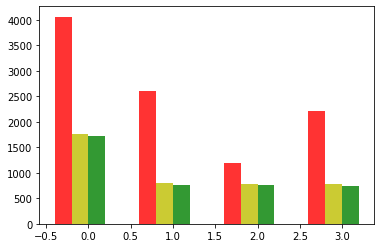

In [46]:
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

res = [0] * 4
res2 = [0] * 4
res3 = [0] * 4
y_test2 = np.concatenate([y_test.values.reshape((-1,1)),y_test_s.values[:,[0,2,3]]],axis = 1).clip(0,1)
for i in range(y_lgbmtsub.shape[0]):
    for j in range(4):
        if y_test2[i,j] == 1:
            res[j] += 1
#             if y_singlelgb[i] > 0.3:
            res2[j] += y_singlelgb[i]
#             if y_lgbmtsub[i,0] > 0.3:
            res3[j] += y_lgbmtsub[i,0]
    
bar1 = plt.bar(x = [i - 0.3 for i in range(len(res))], height = res, width = 0.2,
               alpha = 0.8, color = 'r',label = 'gt')  

bar2 = plt.bar(x = [i - 0.1 for i in range(len(res))], height = res2, width = 0.2,
               alpha = 0.8, color = 'y',label = 'baseline')                  

bar3 = plt.bar(x = [i + 0.1 for i in range(len(res))], height = res3,width = 0.2,
               alpha = 0.8,color = 'g',label = 'mt-gbm')                   


plt.show()

[1, 1, 1, 1] [0.9442728771696625, 0.8404125767539823, 0.9684661390767818, 0.9375276669444391] [0.945400919043679, 0.8589601155349836, 0.9702270283501425, 0.9410505358537014]


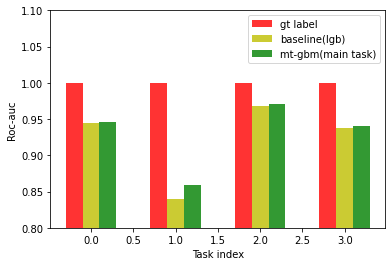

In [63]:
res = [0] * 4
res2 = [0] * 4
res3 = [0] * 4    
for j in range(4):
    res[j] = 1
    res2[j] = roc_auc_score(y_test2[:,j], y_singlelgb[:])
    res3[j] = roc_auc_score(y_test2[:,j], y_lgbmtsub[:,0])

bar1 = plt.bar(x = [i - 0.2 for i in range(len(res))], height = res, width = 0.2,
               alpha = 0.8, color = 'r',label = 'gt label')  

bar2 = plt.bar(x = [i - 0 for i in range(len(res))], height = res2, width = 0.2,
               alpha = 0.8, color = 'y',label = 'baseline(lgb)')                  

bar3 = plt.bar(x = [i + 0.2 for i in range(len(res))], height = res3,width = 0.2,
               alpha = 0.8,color = 'g',label = 'mt-gbm(main task)')                   
print(res,res2,res3)
plt.ylim(0.8,1.1)
plt.xlabel('Task index') 
plt.ylabel('Roc-auc') 
plt.legend() 
plt.show()

[1, 1, 1, 1] [0.9442728771696625, 0.8404125767539823, 0.9684661390767818, 0.9375276669444391] [0.945400919043679, 0.9491546036849549, 0.9924255714013507, 0.9639497661490082]


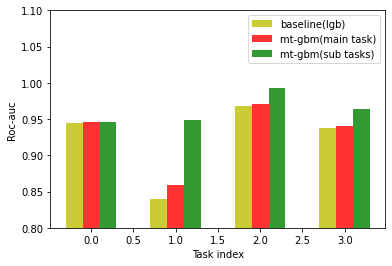

In [65]:
res = [0] * 4
res2 = [0] * 4
res3 = [0] * 4 
res4 = [0] * 4     
for j in range(4):
    res[j] = 1
    res2[j] = roc_auc_score(y_test2[:,j], y_singlelgb[:])
    res3[j] = roc_auc_score(y_test2[:,j], y_lgbmtsub[:,j])
    res4[j] = roc_auc_score(y_test2[:,j], y_lgbmtsub[:,0])


bar2 = plt.bar(x = [i - 0.2 for i in range(len(res))], height = res2, width = 0.2,
               alpha = 0.8, color = 'y',label = 'baseline(lgb)')                  
bar1 = plt.bar(x = [i - 0.0 for i in range(len(res))], height = res4, width = 0.2,
               alpha = 0.8, color = 'r',label = 'mt-gbm(main task)') 
bar3 = plt.bar(x = [i + 0.2 for i in range(len(res))], height = res3,width = 0.2,
               alpha = 0.8,color = 'g',label = 'mt-gbm(sub tasks)')                   
print(res,res2,res3)
plt.ylim(0.8,1.1)
plt.xlabel('Task index') 
plt.ylabel('Roc-auc') 
plt.legend() 
plt.show()